In [1]:
import numpy as np
import os
import sys

import torch
from torch import nn

import importlib

import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython import display
import pickle as pk

sys.path.insert(0, "../src/")
import data
import model

np.random.seed(11111)

In [2]:
def plot_X(X, y, figsize=(16,6), n_row=2, n_col=3, n_show=4, file=None):
    
    fig = plt.figure(figsize=figsize)
    axs = []
    for i in range(n_row):
        for j in range(n_col):
            axs.append(fig.add_subplot(n_row, n_col, (i * n_col) + j + 1))

    for i in range(n_show):
        if X.dim() == 4:
            axs[i].plot(X[i, :, 0, :].T)
        else:
            axs[i].plot(X[i].T)
        if y is not None:
            axs[i].plot(y[i], "r")
        
    fig.tight_layout()
    
    if file is not None:
        plt.savefig(file)
    
    plt.show()
    plt.close()
    
    return

In [3]:
def live_plot_nb(y_out, y_trg, step, n_steps, loss, lr, figsize=(16,6), n_row=1, n_col=2, n_show=2, show_loss=True, log=False, file=None):
    
    display.clear_output(wait=True)
    fig = plt.figure(figsize=figsize)
    axs = []
    for i in range(n_row):
        for j in range(n_col):
            axs.append(fig.add_subplot(n_row, n_col, (i * n_col) + j + 1))

    for i in range(n_show):
        axs[i].plot(y_trg[i])
        axs[i].plot(y_out[i])

    if show_loss:
        axs[i+1].plot(loss)
        axs[i+2].plot(lrs)
    
    if log:
        axs[i+1].set_xscale("log")
        axs[i+1].set_yscale("log")
        axs[i+2].set_xscale("log")
        axs[i+2].set_yscale("log")
    
    fig.tight_layout()
    
    if file is not None:
        plt.savefig(file)
    
    plt.show()
    plt.close()
    
    return

# Define data generation parameters

In [4]:
data_pars = dict(
                 # General parameters
                 td = 256, # Number of points
                 Fs = 12800, # Sampling frequency
                 debug = True, # Print data generation details

                 # Peak parameters
                 pmin = 1, # Minimum number of Gaussians in a peak
                 pmax = 1, # Maximum number of Gaussians in a peak
                 ds = 0.03, # Spread of chemical shift values for each peak
                 lw = [[5e1, 2e2], [1e2, 1e3]], # Linewidth range for Gaussians
                 iso_p = [0.8, 0.2],
                 iso_p_peakwise = True,
                 iso_int = [0.5, 1.], # Intensity
                 phase = 0., # Spread of phase

                 # Isotropic parameters
                 nmin = 1, # Minimum number of peaks
                 nmax = 15, # Maximum number of peaks
                 shift_range = [2000., 10000.], # Chemical shift range
                 positive = True, # Force the spectrum to be positive

                 # MAS-independent parameters
                 mas0_lw_range = [0., 0.], # MAS-independent GLS broadening range
                 mas0_lw_p = [1.],
                 mas0_m_range = [[0., 0.1], [0., 1.]], # MAS-independent GLS mixing paramter
                 mas0_m_p = [0.8, 0.2],
                 mas0_s_range = [0., 0.], # MAS-independent shift range
                 mas0_s_p = [1.],

                 # MAS-dependent parameters
                 mas_lw_range = [[1e7, 1e8], [5e7, 2e8]], # MAS-dependent GLS broadening range
                 mas_lw_p = [0.8, 0.2],
                 mas_m_range = [[1e4, 5e4]], # MAS-dependent GLS mixing paramter
                 mas_m_p = [1.],
                 mas_s_range = [-1.5e7, 1.5e7], # MAS-dependent shift range
                 mas_s_p = [1.],

                 # Second-order MAS-dependent parameters
                 mas_w2 = True,
                 mas_w2_p = 1.0,
                 mas2_lw_range = [[1e2, 1e4], [1e8, 1e9]], # Second-order MAS-dependent Gaussian broadening range
                 mas2_lw_p = [0.5, 0.5],
                 mas2_m_range = [[0., 10], [1e4, 1e6]], # Second-order MAS-dependent Lorentzian broadening range
                 mas2_m_p = [0.5, 0.5],
                 mas2_s_range = [[0., 0.], [-2e11, 2e11]], # Second-order MAS-dependent shift range
                 mas2_s_p = [0.8, 0.2],

                 # Other MAS-dependent mixing
                 mas_other_mixing_p = 0.5,
                 mas_other_mixing_trends = ["constant", "increase", "decrease"],
                 mas_other_mixing_probs = [0.4, 0.3, 0.3],
                 mas_other_mixing_range = [0., 1.],

                 # Add noise to linewidths
                 mas_lw_noise = 0.05,
                 mas_s_noise = 20.,

                 mas_phase = 0.01, # Random phase range for MAS spectra
                 peakwise_phase = True, # Whether the phase should be peak-wise or spectrum-wise
                 encode_imag = False, # Encode the imaginary part of the MAS spectra
                 nw = 8, # Number of MAS rates
                 mas_w_range = [30000, 100000], # MAS rate range
                 random_mas = False,
                 encode_w = True, # Encode the MAS rate of the spectra

                 # Post-processing parameters
                 noise = 0., # Noise level
                 smooth_end_len = 10, # Smooth ends of spectra
                 iso_norm = 256., # Normalization factor for peaks
                 brd_norm = 64., # Normalization factor for MAS spectra
                 offset = 0., # Baseline offset
                 norm_wr = True, # Normalize MAS rate values
                 wr_inv = False, # Encode inverse of MAS rate instead of MAS rate
                )

train_pars = dict(batch_size = 16, # Dataset batch size
                  num_workers = 20, # Number of parallel processes to generate data
                  checkpoint = 1000, # Perform evaluation after that many batches
                  n_eval = 200, # Number of batches in the evaluation
                  max_checkpoints = 200, # Maximum number of checkpoints before finishing training
                  out_dir = "../data/Ensemble_PIPNet_2022_03_03_s_noise_20/", # Output directory
                  change_factor = {50: 0.}, # Checkpoints where
                  avg_models = False,
                  device = "cuda" if torch.cuda.is_available() else "cpu",
                  monitor_end = "\n"
                 )

model_pars = dict(n_models = 9,
                  input_dim = 2,
                  hidden_dim = 32,
                  kernel_size = [5, 15, 25, 35, 45],
                  num_layers = 5,
                  final_kernel_size = 3,
                  batch_input = 6,
                  bias = True,
                  final_bias = True,
                  independent = True,
                  return_all_layers = True,
                  final_act = "linear",
                  noise = 2.e-4,
                 )

fig_dir = "../figures/lstm_sanity_check/"
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

In [5]:
dataset = data.PIPDatasetGLS(**data_pars)

In [6]:
brd_specs, specs, iso = dataset.__getitem__(0)

Generating a spectrum made of 13 peaks...
  Generating a peak of 1 Gaussians around 5298.5890671157795 Hz...
           v[Hz] | dv [Hz] | phi [rad]
    G  1 | 5298.589 | 54.40805 | 0.0000000
  Generating a peak of 1 Gaussians around 2755.367469425939 Hz...
           v[Hz] | dv [Hz] | phi [rad]
    G  1 | 2755.290 | 172.97565 | 0.0000000
  Generating a peak of 1 Gaussians around 2194.6859738851244 Hz...
           v[Hz] | dv [Hz] | phi [rad]
    G  1 | 2194.696 | 107.74769 | 0.0000000
  Generating a peak of 1 Gaussians around 8228.534625401724 Hz...
           v[Hz] | dv [Hz] | phi [rad]
    G  1 | 8228.540 | 114.43573 | 0.0000000
  Generating a peak of 1 Gaussians around 4797.72980335445 Hz...
           v[Hz] | dv [Hz] | phi [rad]
    G  1 | 4797.696 | 163.03774 | 0.0000000
  Generating a peak of 1 Gaussians around 7291.41968619998 Hz...
           v[Hz] | dv [Hz] | phi [rad]
    G  1 | 7291.464 | 76.23750 | 0.0000000
  Generating a peak of 1 Gaussians around 8525.613996045753 Hz...


In [7]:
noisy_brd_specs = brd_specs.clone() + torch.randn_like(brd_specs) * model_pars["noise"]

In [8]:
fig_dir = "../figures/dummy/"
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

In [9]:
ws, _, _, _, _ = dataset.gen_mas1_params(dataset.nw)


  Generated MAS rates:  30000,  40000,  50000,  60000,  70000,  80000,  90000, 100000 Hz
  Generated MAS phases:
    Peak   1           -0.015,  0.007, -0.011,  0.014,  0.005,  0.003, -0.022,  0.002 rad
    Peak   2           -0.002, -0.020, -0.004,  0.002, -0.003, -0.009,  0.009, -0.001 rad
    Peak   3           -0.005,  0.012,  0.021, -0.000,  0.000,  0.013,  0.002,  0.014 rad
    Peak   4           -0.004, -0.002, -0.004, -0.000,  0.016, -0.003, -0.019,  0.010 rad
    Peak   5            0.014, -0.005, -0.002, -0.004,  0.014, -0.014, -0.012,  0.006 rad
    Peak   6           -0.018,  0.003,  0.008, -0.002,  0.001,  0.011,  0.005, -0.024 rad
    Peak   7           -0.002,  0.006,  0.004,  0.003,  0.012, -0.008,  0.001,  0.004 rad
    Peak   8            0.010,  0.017,  0.001,  0.006, -0.010, -0.014,  0.001, -0.009 rad

  Generating MAS-dependent parameters...
                lw [Hz^2] |     m     |  s [Hz^2]
    Peak   1     2.24e+07 |  1.51e+04 | -6.86e+06
    Peak   2     9.76e+0

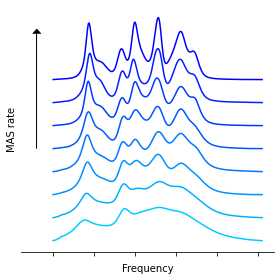

In [10]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)

c0 = np.array([0., 0.8, 1.])
c1 = np.array([0., -0.8, 0.])

for i, (w, s) in enumerate(zip(ws, brd_specs[:, 0, :])):
    ax.plot(s + i * 0.1, c=c0 + i / (len(ws) - 1) * c1)
    
ax.arrow(-20, 0.1 * len(ws) / 2, 0, 0.5, head_width=10., head_length=0.02, color="k", linewidth=0.5)
    
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xlabel("Frequency")
ax.set_ylabel("MAS rate")
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

fig.tight_layout()

plt.savefig(f"{fig_dir}MAS_example_phase_{dataset.mas_phase}.pdf")

plt.show()
plt.close()

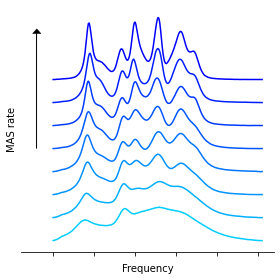

In [11]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)

c0 = np.array([0., 0.8, 1.])
c1 = np.array([0., -0.8, 0.])

for i, (w, s) in enumerate(zip(ws, noisy_brd_specs[:, 0, :])):
    ax.plot(s + i * 0.1, c=c0 + i / (len(ws) - 1) * c1)
    
ax.arrow(-20, 0.1 * len(ws) / 2, 0, 0.5, head_width=10., head_length=0.02, color="k", linewidth=0.5)
    
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xlabel("Frequency")
ax.set_ylabel("MAS rate")
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

fig.tight_layout()

plt.savefig(f"{fig_dir}MAS_example_phase_{dataset.mas_phase}_noisy.pdf")

plt.show()
plt.close()

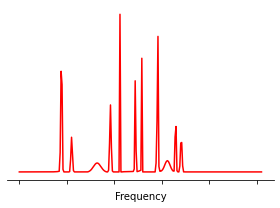

In [12]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

c0 = np.array([0., 0.8, 1.])
c1 = np.array([0., -0.8, 0.])

ax.plot(iso[0], color="r")

ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xlabel("Frequency")
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

fig.tight_layout()

plt.savefig(f"{fig_dir}MAS_example_trg.pdf")
plt.show()
plt.close()

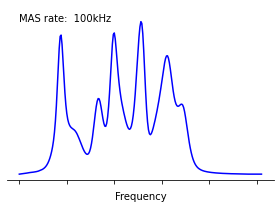

In [13]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

plot, = ax.plot(brd_specs[0, 0], c=c0)
text = ax.text(0, torch.max(brd_specs[:, 0]), f"MAS rate: {ws[0]/1000: 4.0f}kHz")

h = 1.

def init():
    ax.set_ylim(-0.01, torch.max(brd_specs[:, 0]) * 1.1)
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xlabel("Frequency")
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    fig.tight_layout()
#    text, = ax.text(0, h, f"MAS rate: {ws[0]}")
    return fig, plot

def update(i):
    plot.set_ydata(brd_specs[i, 0])
    plot.set_color(c0 + i / (len(ws) - 1) * c1)
    text.set_text(f"MAS rate: {ws[i]/1000: 4.0f}kHz")
    return fig, plot

A = anim.FuncAnimation(fig, update, frames=len(ws), init_func=init)

A.save(f"{fig_dir}MAS_example_anim_phase_{dataset.mas_phase}.mp4", fps=30, dpi=200)

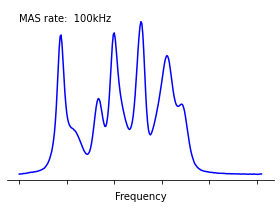

In [14]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

plot, = ax.plot(noisy_brd_specs[0, 0], c=c0)
text = ax.text(0, torch.max(noisy_brd_specs[:, 0]), f"MAS rate: {ws[0]/1000: 4.0f}kHz")

h = 1.

def init():
    ax.set_ylim(-0.01, torch.max(noisy_brd_specs[:, 0]) * 1.1)
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xlabel("Frequency")
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    fig.tight_layout()
#    text, = ax.text(0, h, f"MAS rate: {ws[0]}")
    return fig, plot

def update(i):
    plot.set_ydata(noisy_brd_specs[i, 0])
    plot.set_color(c0 + i / (len(ws) - 1) * c1)
    text.set_text(f"MAS rate: {ws[i]/1000: 4.0f}kHz")
    return fig, plot

A = anim.FuncAnimation(fig, update, frames=len(ws), init_func=init)

A.save(f"{fig_dir}MAS_example_anim_phase_{dataset.mas_phase}_noisy.mp4", fps=30, dpi=200)

# Make predictions

In [15]:
mod_dir = "../data/Ensemble_PIPNet_2022_03_03_s_noise_20/"
par_dir = "../figures/Ensemble_PIPNet_2022_03_03_s_noise_20/"

model_pars["noise"] = 0.

# Load loss
all_losses = np.load(mod_dir + "all_losses.npy")
all_val_losses = np.load(mod_dir + "all_val_losses.npy")

mean_losses = np.mean(all_losses, axis=1)
mean_val_losses = np.mean(all_val_losses, axis=1)

best_chk = np.argmin(mean_val_losses)
print(best_chk)

with open(f"{par_dir}params.pk", "rb") as F:
    [model_pars, loss_pars, data_pars] = pk.load(F)

net = model.ConvLSTMEnsemble(**model_pars)

168


In [16]:
net.load_state_dict(torch.load(mod_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))
net.eval()

with torch.no_grad():
    y_pred, y_std, ys = net(brd_specs.unsqueeze(0))

In [17]:
y_pred.shape

torch.Size([1, 3, 256])

In [18]:
y_std.shape

torch.Size([1, 3, 256])

In [19]:
ys.shape

torch.Size([9, 1, 3, 256])

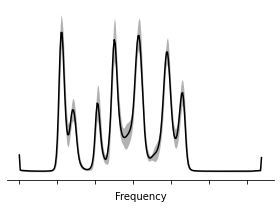

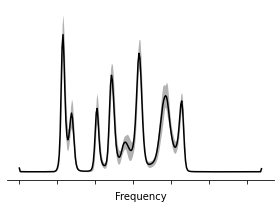

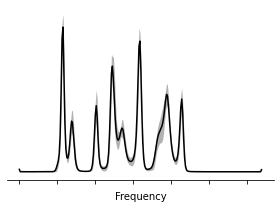

In [20]:
for i, (pred, std) in enumerate(zip(y_pred[0].numpy(), y_std[0].numpy())):
    
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)

    ax.fill_between(dataset.f, pred-std, pred+std, color="k", alpha=0.3, linewidths=0)
    ax.plot(dataset.f, pred, color="k")

    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xlabel("Frequency")
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    fig.tight_layout()

    plt.savefig(f"{fig_dir}pred_step_{i+1}.pdf")
    plt.show()
    plt.close()